# 7:3 Train/Test Ratio

In [1]:
# import libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
# read data
df = pd.read_csv('VCB.csv')
df = df[['Price','Open','High']]

In [3]:
# Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)    

C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbos

,Price_x,Open_x,High_x
Price_y,1.0,0.004,0.0
Open_y,0.0,1.000,0.0
High_y,0.0,0.000,1.0


In [4]:
# Cointegration Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  514.32    > 24.2761   =>   True
Open   ::  167.55    > 12.3212   =>   True
High   ::  0.54      > 4.1296    =>   False


In [5]:
df =  df[['Price','Open']]

In [6]:
# check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -1.142023
p-value: 0.698026




In [7]:
# differencing
from statsmodels.tsa.stattools import adfuller
df_difference = df.diff().dropna()
adf1 = adfuller(df_difference['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -30.674165
p-value: 0.000000




In [8]:
# Split train/test
train_size = int(0.3 * len(df))
train = df_difference[:-train_size]
test = df_difference[-train_size:]

In [9]:
# find the best fit model
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  25.740602422700874
BIC:  25.75938277574692

Order = 2
AIC:  25.568906121756708
BIC:  25.600221364362074

Order = 3
AIC:  25.4261175018229
BIC:  25.46997937823492

Order = 4
AIC:  25.348433473806086
BIC:  25.404853746221097

Order = 5
AIC:  25.321169987957507
BIC:  25.39016043655858

Order = 6
AIC:  25.300971018439906
BIC:  25.382543441434724

Order = 7
AIC:  25.290341671777835
BIC:  25.3845078854366

Order = 8
AIC:  25.276356857088427
BIC:  25.383128695781956

Order = 9
AIC:  25.264663331693676
BIC:  25.384052647931515

Order = 10
AIC:  25.245417755411516
BIC:  25.377436419880212



C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored 

In [10]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,26.86,26.86,4.610e+11,26.86
1,25.75,25.77,1.529e+11,25.76
2,25.58,25.61,1.286e+11,25.59
3,25.44,25.48,1.114e+11,25.45
4,25.36,25.41,1.029e+11,25.38
5,25.33,25.40,1.001e+11,25.35
6,25.31,25.39,9.796e+10,25.34
7,25.30,25.39,9.681e+10,25.33
8,25.28,25.39,9.536e+10,25.32
9,25.27,25.39,9.414e+10,25.31


In [11]:
result = model.fit(10)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Dec, 2023
Time:                     00:57:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    25.3774
Nobs:                     1737.00    HQIC:                   25.2942
Log likelihood:          -26813.0    FPE:                9.20337e+10
AIC:                      25.2454    Det(Omega_mle):     8.98480e+10
--------------------------------------------------------------------
Results for equation Price
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            34.542944        18.259859            1.892           0.059
L1.Price         -0.000171         0.025902           -0.007           0.995
L1.Open           0.008294         0.045107            0.184           0.854

In [12]:
# Get the lag order
lag_order = result.k_ar
lagged_Values = train.values[-lag_order:]

# Forecast
pred = result.forecast(y=lagged_Values, steps=len(test)+30) 

idx = pd.RangeIndex(start=len(train), stop=len(df)+29, step=1)
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['price_1d', 'open_1d'])

In [13]:
# Convert differenced values into original values
df_forecast['PriceForecast'] = df['Price'].iloc[-train_size-1] + df_forecast['price_1d'].cumsum()
df_forecast['OpenForecast'] = df['Open'].iloc[-train_size-1] + df_forecast['open_1d'].cumsum()
df_forecast_30 = df_forecast[-30:]
df_forecast = df_forecast[:-30]

In [14]:
# Evaluating
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error
test_score_rmse_lstm = np.sqrt(mean_squared_error(df[-train_size:]['Price'], df_forecast['PriceForecast']))
test_score_mape_lstm = mean_absolute_percentage_error(df[-train_size:]['Price'], df_forecast['PriceForecast']) * 100
test_score_msle_lstm = mean_squared_log_error(df[-train_size:]['Price'], df_forecast['PriceForecast'])

print('RMSE trên tập test là:', test_score_rmse_lstm)
print('MAPE trên tập test là:', test_score_mape_lstm)
print('MSLE trên tập test là:', test_score_msle_lstm)

RMSE trên tập test là: 9684.298843023053
MAPE trên tập test là: 9.829346491175981
MSLE trên tập test là: 0.012989914273960653


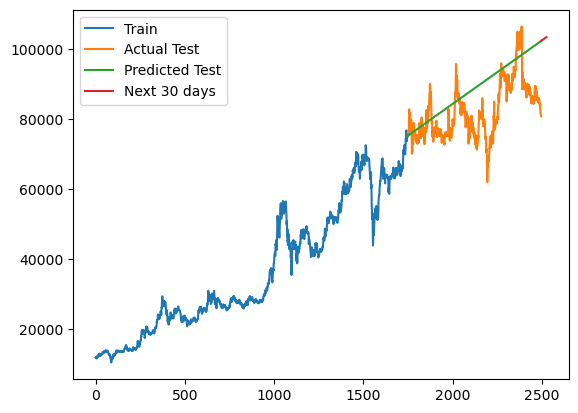

In [15]:
# Plot
plt.plot(df[:-train_size].index, df[:-train_size]['Price'], label='Train')
plt.plot(test.index, df[-train_size:]['Price'], label='Actual Test')
plt.plot(df[-train_size:].index, df_forecast['PriceForecast'], label='Predicted Test')
plt.plot(df_forecast_30.index, df_forecast_30['PriceForecast'], label='Next 30 days')
plt.legend()
plt.show()

# 8:2 Tran/Test Ratio

In [16]:
# import libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [17]:
# read data
df = pd.read_csv('VCB.csv')
df = df[['Price','Open','High']]

In [18]:
# Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)    

C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbos

,Price_x,Open_x,High_x
Price_y,1.0,0.004,0.0
Open_y,0.0,1.000,0.0
High_y,0.0,0.000,1.0


In [19]:
# Cointegration Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  514.32    > 24.2761   =>   True
Open   ::  167.55    > 12.3212   =>   True
High   ::  0.54      > 4.1296    =>   False


In [20]:
df =  df[['Price','Open']]

In [21]:
# check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -1.142023
p-value: 0.698026




In [22]:
# differencing
from statsmodels.tsa.stattools import adfuller
df_difference = df.diff().dropna()
adf1 = adfuller(df_difference['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -30.674165
p-value: 0.000000




In [23]:
# Split train/test
train_size = int(0.2 * len(df))
train = df_difference[:-train_size]
test = df_difference[-train_size:]

In [24]:
# find the best fit model
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  26.20853715009697
BIC:  26.22537444131298

Order = 2
AIC:  26.0650494477752
BIC:  26.09312315866046

Order = 3
AIC:  25.94436622449768
BIC:  25.98368561661157

Order = 4
AIC:  25.856372879022146
BIC:  25.906947226354777

Order = 5
AIC:  25.81904678180451
BIC:  25.880885370799692

Order = 6
AIC:  25.806447251653122
BIC:  25.879559381231353

Order = 7
AIC:  25.797652282705805
BIC:  25.882047264287312

Order = 8
AIC:  25.78236466210186
BIC:  25.878051819629707

Order = 9
AIC:  25.765106304349445
BIC:  25.87209497431269

Order = 10
AIC:  25.741422506339084
BIC:  25.85972203779599



C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored 

In [25]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,27.32,27.32,7.296e+11,27.32
1,26.22,26.24,2.438e+11,26.23
2,26.07,26.10,2.110e+11,26.09
3,25.95,25.99,1.868e+11,25.97
4,25.86,25.92,1.709e+11,25.88
5,25.83,25.89,1.645e+11,25.85
6,25.81,25.89,1.623e+11,25.84
7,25.80,25.89,1.607e+11,25.83
8,25.79,25.88,1.581e+11,25.82
9,25.77,25.88,1.552e+11,25.81


In [26]:
result = model.fit(10)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Dec, 2023
Time:                     00:57:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    25.8597
Nobs:                     1986.00    HQIC:                   25.7849
Log likelihood:          -31155.3    FPE:                1.51133e+11
AIC:                      25.7414    Det(Omega_mle):     1.47987e+11
--------------------------------------------------------------------
Results for equation Price
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            33.256726        19.419023            1.713           0.087
L1.Price         -0.019272         0.024083           -0.800           0.424
L1.Open           0.060014         0.042658            1.407           0.159

In [27]:
# Get the lag order
lag_order = result.k_ar
lagged_Values = train.values[-lag_order:]

# Forecast
pred = result.forecast(y=lagged_Values, steps=len(test)+30) 

idx = pd.RangeIndex(start=len(train), stop=len(df)+29, step=1)
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['price_1d', 'open_1d'])

In [28]:
# Convert differenced values into original values
df_forecast['PriceForecast'] = df['Price'].iloc[-train_size-1] + df_forecast['price_1d'].cumsum()
df_forecast['OpenForecast'] = df['Open'].iloc[-train_size-1] + df_forecast['open_1d'].cumsum()
df_forecast_30 = df_forecast[-30:]
df_forecast = df_forecast[:-30]

In [29]:
# Evaluating
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error
test_score_rmse_lstm = np.sqrt(mean_squared_error(df[-train_size:]['Price'], df_forecast['PriceForecast']))
test_score_mape_lstm = mean_absolute_percentage_error(df[-train_size:]['Price'], df_forecast['PriceForecast']) * 100
test_score_msle_lstm = mean_squared_log_error(df[-train_size:]['Price'], df_forecast['PriceForecast'])

print('RMSE trên tập test là:', test_score_rmse_lstm)
print('MAPE trên tập test là:', test_score_mape_lstm)
print('MSLE trên tập test là:', test_score_msle_lstm)

RMSE trên tập test là: 7200.996660367288
MAPE trên tập test là: 6.9631637099416706
MSLE trên tập test là: 0.0073538145135593706


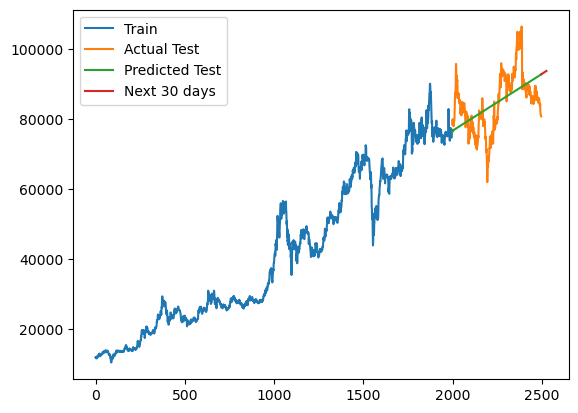

In [30]:
# Plot
plt.plot(df[:-train_size].index, df[:-train_size]['Price'], label='Train')
plt.plot(test.index, df[-train_size:]['Price'], label='Actual Test')
plt.plot(df[-train_size:].index, df_forecast['PriceForecast'], label='Predicted Test')
plt.plot(df_forecast_30.index, df_forecast_30['PriceForecast'], label='Next 30 days')
plt.legend()
plt.show()

# 9:1 Train/Test Ratio

In [31]:
# import libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

#read data
df = pd.read_csv('VCB.csv')
df = df[['Price','Open','High']]

In [32]:
# Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)    

C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbos

,Price_x,Open_x,High_x
Price_y,1.0,0.004,0.0
Open_y,0.0,1.000,0.0
High_y,0.0,0.000,1.0


In [33]:
# Cointegration Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  514.32    > 24.2761   =>   True
Open   ::  167.55    > 12.3212   =>   True
High   ::  0.54      > 4.1296    =>   False


In [34]:
df =  df[['Price','Open']]

In [35]:
# check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -1.142023
p-value: 0.698026




In [36]:
# differencing
from statsmodels.tsa.stattools import adfuller
df_difference = df.diff().dropna()
adf1 = adfuller(df_difference['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -30.674165
p-value: 0.000000




In [37]:
# Split train/test
train_size = int(0.1 * len(df))
train = df_difference[:-train_size]
test = df_difference[-train_size:]

In [38]:
# find the best fit model
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  26.594253934963515
BIC:  26.609531781200065

Order = 2
AIC:  26.41882563064619
BIC:  26.444298069445846

Order = 3
AIC:  26.33117472964943
BIC:  26.36684926085018

Order = 4
AIC:  26.256356780312483
BIC:  26.302240912723445

Order = 5
AIC:  26.228781883154475
BIC:  26.284883134570638

Order = 6
AIC:  26.206361227103173
BIC:  26.27268712432017

Order = 7
AIC:  26.193463261409423
BIC:  26.270021340238348

Order = 8
AIC:  26.17077678953403
BIC:  26.257574594816266

Order = 9
AIC:  26.15918157826235
BIC:  26.256226663884444

Order = 10
AIC:  26.1377336443373
BIC:  26.245033573245863



C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored 

In [39]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,27.65,27.66,1.019e+12,27.65
1,26.60,26.62,3.581e+11,26.61
2,26.43,26.45,3.002e+11,26.44
3,26.34,26.37,2.747e+11,26.35
4,26.26,26.31,2.547e+11,26.28
5,26.23,26.29,2.476e+11,26.26
6,26.21,26.28,2.419e+11,26.24
7,26.20,26.27,2.386e+11,26.23
8,26.17,26.26,2.330e+11,26.21
9,26.16,26.26,2.301e+11,26.20


In [40]:
result = model.fit(10)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Dec, 2023
Time:                     00:58:12
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    26.2450
Nobs:                     2236.00    HQIC:                   26.1769
Log likelihood:          -35525.5    FPE:                2.24633e+11
AIC:                      26.1377    Det(Omega_mle):     2.20473e+11
--------------------------------------------------------------------
Results for equation Price
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            30.471425        20.069211            1.518           0.129
L1.Price          0.006774         0.022378            0.303           0.762
L1.Open           0.076422         0.039821            1.919           0.055

In [41]:
# Get the lag order
lag_order = result.k_ar
lagged_Values = train.values[-lag_order:]

# Forecast
pred = result.forecast(y=lagged_Values, steps=len(test)+30) 

idx = pd.RangeIndex(start=len(train), stop=len(df)+29, step=1)
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['price_1d', 'open_1d'])

In [42]:
# Convert differenced values into original values
df_forecast['PriceForecast'] = df['Price'].iloc[-train_size-1] + df_forecast['price_1d'].cumsum()
df_forecast['OpenForecast'] = df['Open'].iloc[-train_size-1] + df_forecast['open_1d'].cumsum()
df_forecast_30 = df_forecast[-30:]
df_forecast = df_forecast[:-30]

In [43]:
# Evaluating
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error
test_score_rmse_lstm = np.sqrt(mean_squared_error(df[-train_size:]['Price'], df_forecast['PriceForecast']))
test_score_mape_lstm = mean_absolute_percentage_error(df[-train_size:]['Price'], df_forecast['PriceForecast']) * 100
test_score_msle_lstm = mean_squared_log_error(df[-train_size:]['Price'], df_forecast['PriceForecast'])

print('RMSE trên tập test là:', test_score_rmse_lstm)
print('MAPE trên tập test là:', test_score_mape_lstm)
print('MSLE trên tập test là:', test_score_msle_lstm)

RMSE trên tập test là: 10112.090967050424
MAPE trên tập test là: 8.643756198249706
MSLE trên tập test là: 0.012846916716436849


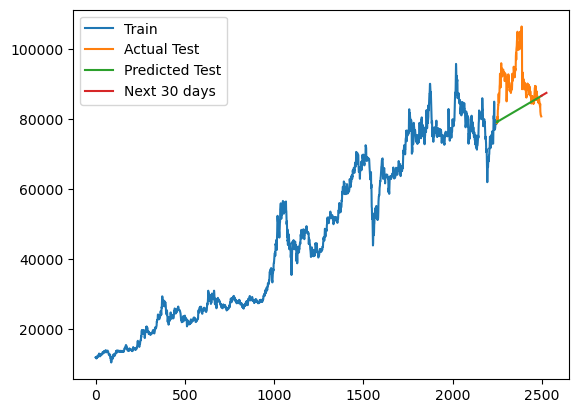

In [44]:
# Plot
plt.plot(df[:-train_size].index, df[:-train_size]['Price'], label='Train')
plt.plot(test.index, df[-train_size:]['Price'], label='Actual Test')
plt.plot(df[-train_size:].index, df_forecast['PriceForecast'], label='Predicted Test')
plt.plot(df_forecast_30.index, df_forecast_30['PriceForecast'], label='Next 30 days')
plt.legend()
plt.show()